In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from featuer_extraction import extract_features_from_info
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [2]:
path_to_data = 'data/ECU_IoHT.xlsx'
data = pd.read_excel(path_to_data)

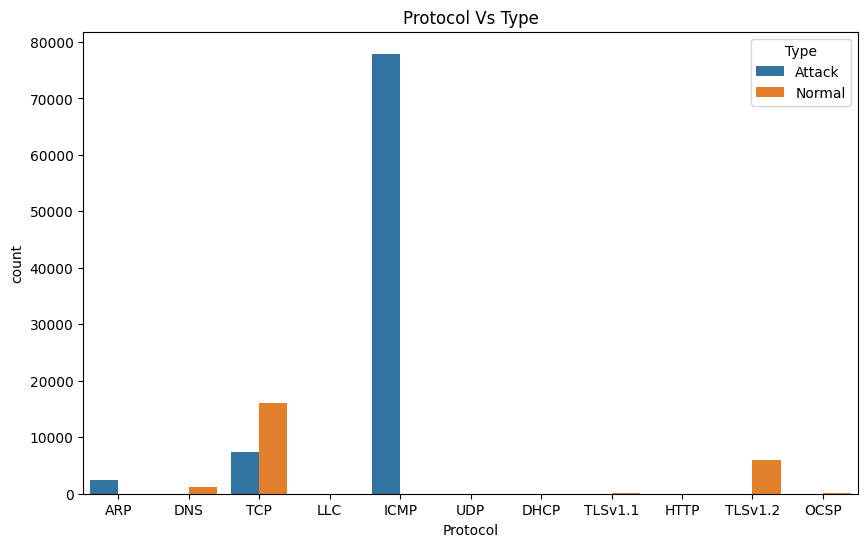

In [3]:
columns_to_plot = [
    'Protocol', ]

for column in columns_to_plot:
    plt.figure(figsize=(10,6))
    sns.countplot(x=column, hue='Type', data= data)
    plt.title(f'{column} Vs Type')
    plt.show()

In [4]:
# Extract rows where protocol == 'TCP'
tcp_rows = data[data['Protocol'] == 'TCP']
tcp_rows.shape

(23494, 9)

In [5]:
tcp_rows.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Type,Type of attack
6,7,0.433064,192.168.43.186,192.168.43.1,TCP,58,36954 > 1720 [SYN] Seq=0 Win=1024 Len=0 MSS=...,Normal,No Attack
7,8,0.433084,192.168.43.186,192.168.43.1,TCP,58,36954 > 5900 [SYN] Seq=0 Win=1024 Len=0 MSS=...,Normal,No Attack
8,9,0.433089,192.168.43.186,192.168.43.1,TCP,58,36954 > 135 [SYN] Seq=0 Win=1024 Len=0 MSS=1460,Normal,No Attack
9,10,0.433092,192.168.43.186,192.168.43.1,TCP,58,36954 > 143 [SYN] Seq=0 Win=1024 Len=0 MSS=1460,Normal,No Attack
10,11,0.433096,192.168.43.186,192.168.43.1,TCP,58,36954 > 993 [SYN] Seq=0 Win=1024 Len=0 MSS=1460,Normal,No Attack


In [6]:
tcp_df = extract_features_from_info(tcp_rows)
tcp_df.shape

(23494, 28)

In [7]:
tcp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 6 to 111201
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   No.               23494 non-null  int64  
 1   Time              23494 non-null  float64
 2   Source            23494 non-null  object 
 3   Destination       23494 non-null  object 
 4   Protocol          23494 non-null  object 
 5   Length            23494 non-null  int64  
 6   Info              23494 non-null  object 
 7   Type              23494 non-null  object 
 8   Type of attack    23494 non-null  object 
 9   source_port       23494 non-null  int64  
 10  destination_port  23494 non-null  int64  
 11  seq               23494 non-null  int64  
 12  transaction_id    0 non-null      float64
 13  length            23494 non-null  int64  
 14  win               23494 non-null  int64  
 15  mss               8097 non-null   float64
 16  ack               14476 non-null  float64
 1

In [8]:
cols_not_null_inferior1000 = tcp_df.loc[:,tcp_df.notna().sum() <= 1000].columns
print("the columns with the value of not null inferior to 1000:")
cols_not_null_inferior1000.to_list()

the columns with the value of not null inferior to 1000:


['transaction_id',
 'ws',
 'urg',
 'sack_perm',
 'ttl',
 'seq_ack',
 'ack_num',
 'who_has_ip',
 'tell_ip']

In [9]:
print('Showing how much NULL values in those columns.')
tcp_df[cols_not_null_inferior1000].isnull().sum()

Showing how much NULL values in those columns.


transaction_id    23494
ws                23092
urg               23485
sack_perm         23092
ttl               23494
seq_ack           23285
ack_num           23285
who_has_ip        23494
tell_ip           23494
dtype: int64

In [10]:
print('shape of data frame before droping the columns: ', tcp_df.shape)
tcp_df = tcp_df.drop(cols_not_null_inferior1000, axis=1)
print('shape of data frame after droping the columns: ', tcp_df.shape)

shape of data frame before droping the columns:  (23494, 28)
shape of data frame after droping the columns:  (23494, 19)


In [11]:
tcp_df[tcp_df.columns.to_list()].isnull().sum()

No.                     0
Time                    0
Source                  0
Destination             0
Protocol                0
Length                  0
Info                    0
Type                    0
Type of attack          0
source_port             0
destination_port        0
seq                     0
length                  0
win                     0
mss                 15397
ack                  9018
tsval               15859
tsecr               15859
rest_of_info            0
dtype: int64

In [12]:
columns_to_drop = ['No.', 'Time', 'Info', 'rest_of_info']
tcp_df = tcp_df.drop(columns_to_drop, axis= 1)
tcp_df.columns 

Index(['Source', 'Destination', 'Protocol', 'Length', 'Type', 'Type of attack',
       'source_port', 'destination_port', 'seq', 'length', 'win', 'mss', 'ack',
       'tsval', 'tsecr'],
      dtype='object')

In [13]:
columns_have_ip = ['Source', 'Destination']
IP_sets = [set(tcp_df[col].unique()) for col in columns_have_ip]
all_IPs = IP_sets[0] | IP_sets[1] 
print(f'all IP adresses in the dataset: {len(all_IPs)}')

ip_to_num = {
    ip: i for i, ip in enumerate(all_IPs) 
}
ip_to_num[np.nan] = np.nan

all IP adresses in the dataset: 67


In [14]:
for col in columns_have_ip:
    tcp_df[col] = tcp_df[col].apply(lambda ip: ip_to_num[ip])

tcp_df[columns_have_ip].dtypes

Source         int64
Destination    int64
dtype: object

In [15]:
resr_categorical_columns = tcp_df.select_dtypes(include=['object']).columns
print(f"the remaining columns that need to be encoded:\n{resr_categorical_columns.to_list()}")

the remaining columns that need to be encoded:
['Protocol', 'Type', 'Type of attack']


In [16]:
tcp_df['Protocol'].nunique()

1

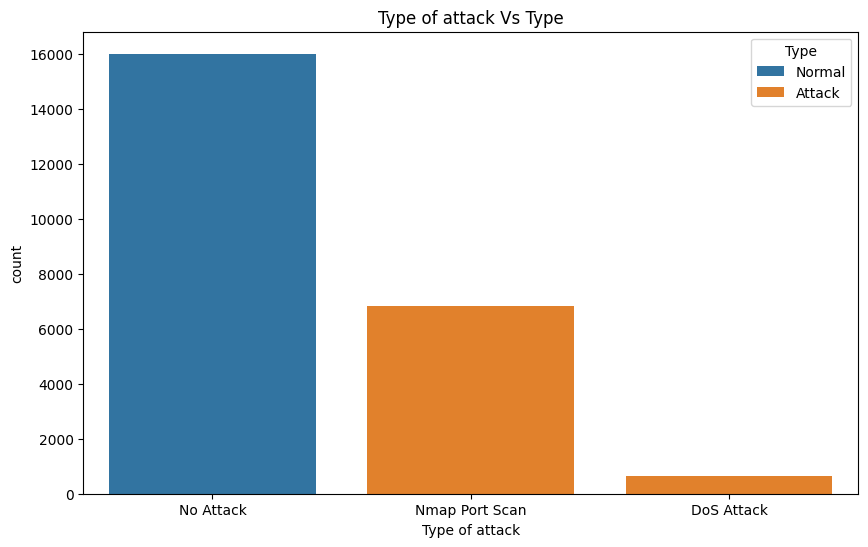

In [17]:
columns_to_plot = [
    'Type of attack', ]

for column in columns_to_plot:
    plt.figure(figsize=(10,6))
    sns.countplot(x=column, hue='Type', data= tcp_df)
    plt.title(f'{column} Vs Type')
    plt.show()

In [18]:
columns_to_drop = ['Type of attack', 'Protocol']
tcp_df = tcp_df.drop(columns= columns_to_drop)
tcp_df.columns

Index(['Source', 'Destination', 'Length', 'Type', 'source_port',
       'destination_port', 'seq', 'length', 'win', 'mss', 'ack', 'tsval',
       'tsecr'],
      dtype='object')

In [19]:
type_encoder = {'Attack': 1, 'Normal': 0}
type_encoder_inverse = {v:k for k, v in type_encoder.items()}
tcp_df['Type'] = tcp_df['Type'].map(type_encoder)

In [20]:
resr_categorical_columns = tcp_df.select_dtypes(include=['object']).columns
print(f"the remaining columns that need to be encoded:\n{resr_categorical_columns.to_list()}")

the remaining columns that need to be encoded:
[]


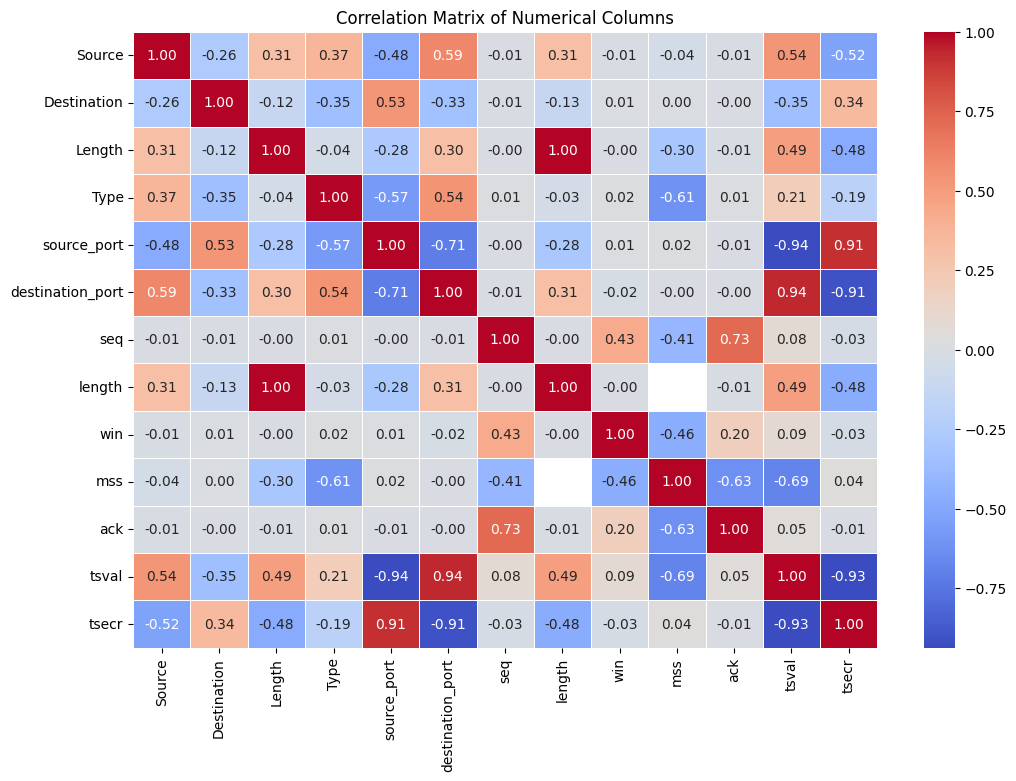

In [21]:

correlation_matrix = tcp_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

In [22]:
columns_have_a_correlation_with_athers = ['length', 'tsval', 'tsecr']
tcp_df[columns_have_a_correlation_with_athers].isnull().sum()/len(tcp_df) 

length    0.000000
tsval     0.675023
tsecr     0.675023
dtype: float64

In [23]:
columns_to_drop = ['Type of attack', 'Protocol']
tcp_df = tcp_df.drop(columns= columns_have_a_correlation_with_athers[0:])
tcp_df.columns

Index(['Source', 'Destination', 'Length', 'Type', 'source_port',
       'destination_port', 'seq', 'win', 'mss', 'ack'],
      dtype='object')

In [24]:
tcp_df[tcp_df.columns].isnull().sum()/len(tcp_df) 

Source              0.000000
Destination         0.000000
Length              0.000000
Type                0.000000
source_port         0.000000
destination_port    0.000000
seq                 0.000000
win                 0.000000
mss                 0.655359
ack                 0.383843
dtype: float64

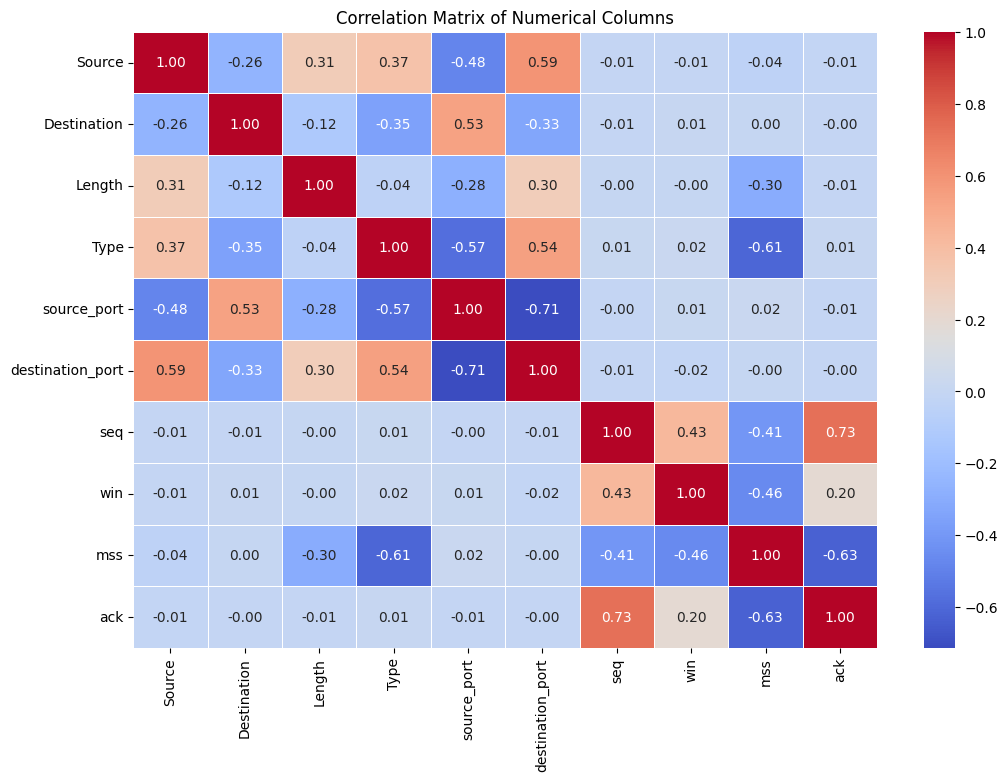

In [25]:
correlation_matrix = tcp_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

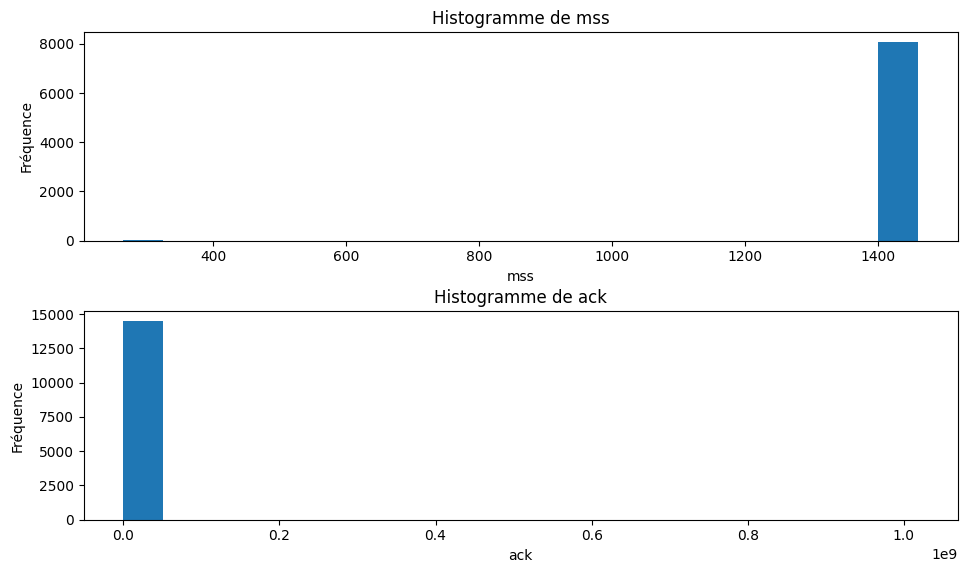

In [30]:
df = tcp_df.copy()  # Ensure tcp_df is defined
numerical_cols = df.select_dtypes(include=np.number).columns
numerical_cols = [col for col in numerical_cols if tcp_df[col].isna().any()]

num_cols = len(numerical_cols)
if num_cols > 0:
    fig, axes = plt.subplots(nrows=num_cols, figsize=(10, 3 * num_cols))
    fig.tight_layout(pad=3.0)

    # Handle cases where only one subplot is created
    if num_cols == 1:
        axes = [axes]

    for i, col in enumerate(numerical_cols):
        ax = axes[i]
        ax.hist(tcp_df[col].dropna(), bins=20)  # Drop NaN values before plotting
        ax.set_title(f'Histogramme de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Fréquence')

    plt.show()
else:
    print("No numerical columns with missing values to plot.")


In [38]:
tcp_df

['mss', 'ack']

In [40]:
method_columns = {
    'median':['mss', 'ack'] 
}
for method, columns in method_columns.items():
    if method == 'median':
        for column in columns:
            tcp_df[column] = tcp_df[column].fillna(tcp_df[column].median())
    elif method == 'mean':
        for column in columns:
            tcp_df[column] = tcp_df[column].fillna(tcp_df[column].mean())

In [43]:
tcp_df.isnull().sum()

Source              0
Destination         0
Length              0
Type                0
source_port         0
destination_port    0
seq                 0
win                 0
mss                 0
ack                 0
dtype: int64

In [76]:
X = tcp_df.drop(columns=['Type'])
labels = tcp_df['Type']
X.shape

(23494, 9)

In [66]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

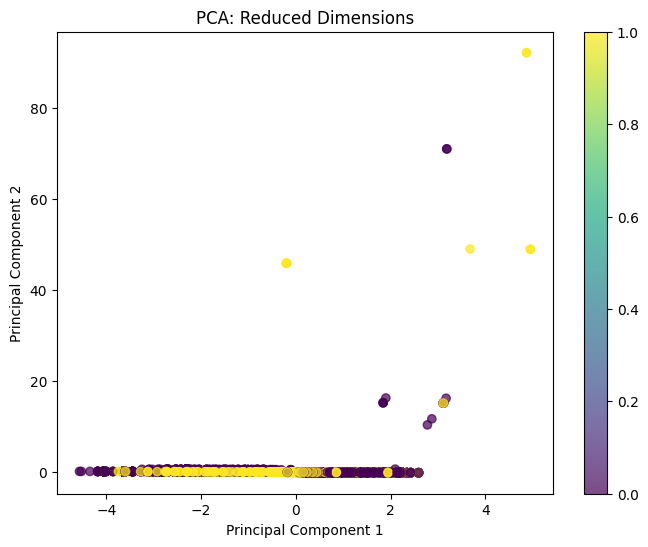

Explained Variance Ratio: [0.29463735 0.22121677 0.12833332 0.10281736 0.07949332 0.06084401
 0.05241874 0.03393739 0.02630173]


In [82]:
pca = PCA()  
X_pca = pca.fit_transform(scaled_data)


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)  # Replace 'labels' with your data labels
plt.title("PCA: Reduced Dimensions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

# Print explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


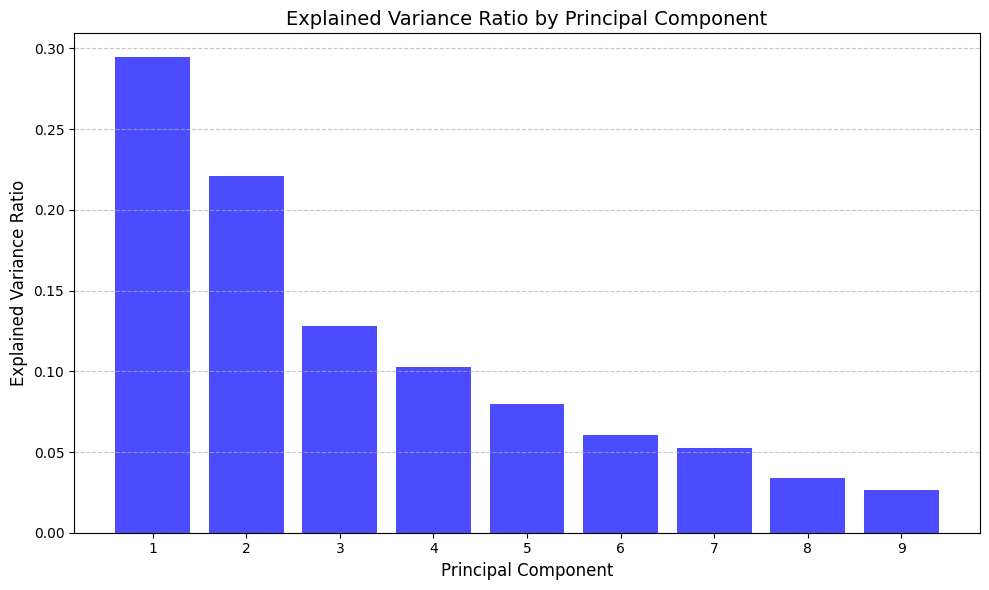

In [83]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')

# Add labels and title
plt.title("Explained Variance Ratio by Principal Component", fontsize=14)
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Explained Variance Ratio", fontsize=12)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))  # Label each component
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

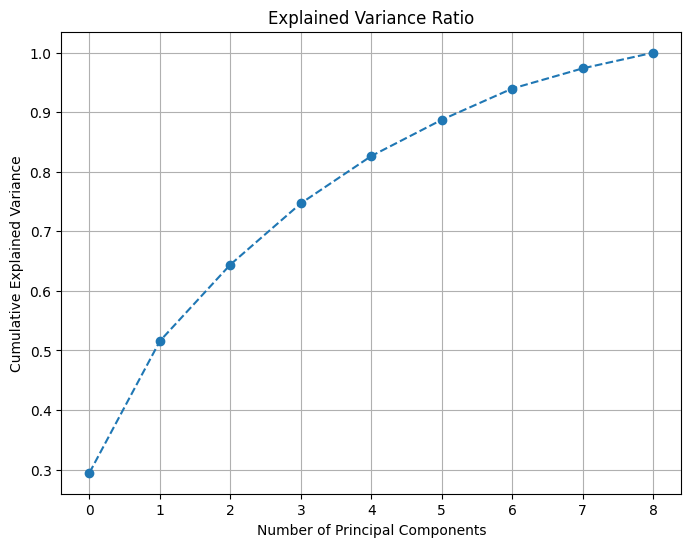

In [84]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.grid()
plt.show()

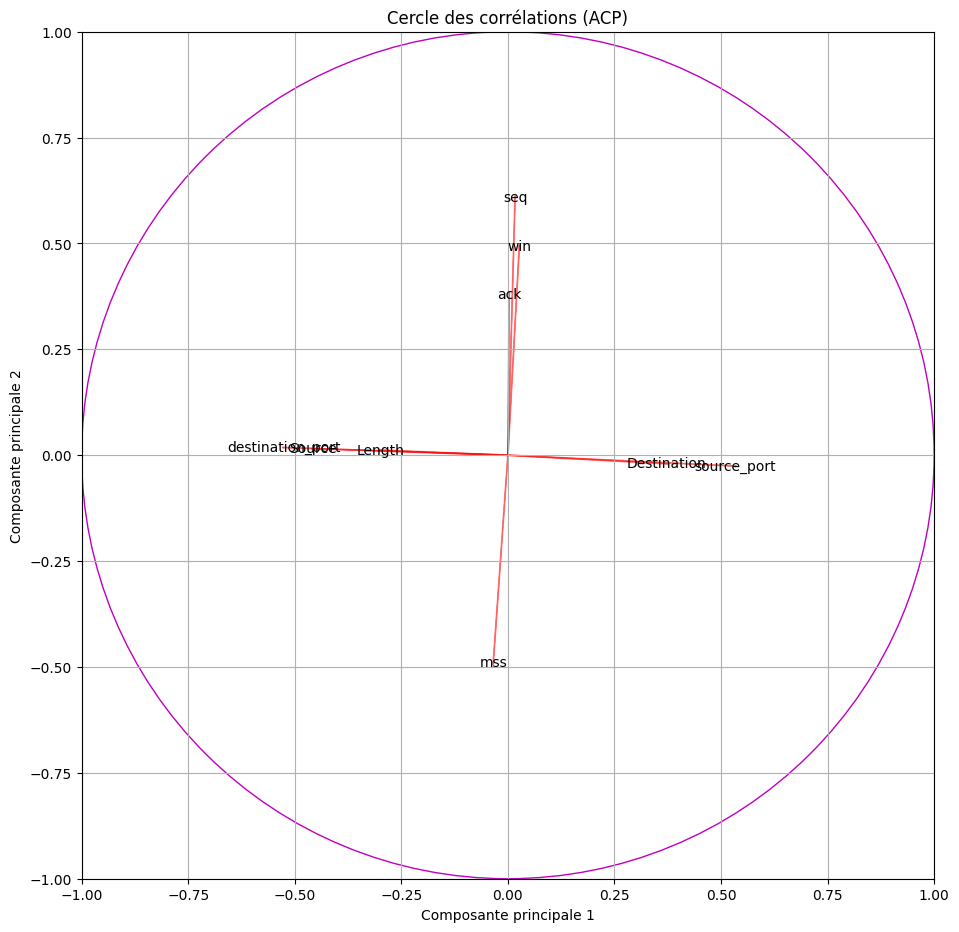

In [86]:
# Affichage du cercle des corrélations
fig, axes = plt.subplots(figsize=(11, 11))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Cercle unité
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='m')
axes.add_artist(circle)

# Afficher les coordonnées des variables sur le cercle des corrélations
for i, variable in enumerate(X.columns):
    x = pca.components_[0, i]
    y = pca.components_[1, i]
    plt.arrow(0, 0, x, y, color='r', alpha=0.5)
    plt.text(x, y, variable,  ha='center', va='center')

plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Cercle des corrélations (ACP)")
plt.grid(True)
plt.show()

____

In [ ]:
X = tcp_df.drop(columns=['Type'])
y = tcp_df['Type']
x_train, X_test, y_

In [ ]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(sampling_strategy=0.2, random_state=0)  # Adjust the ratio as needed
X_trainnew, y_trainnew = over_sampler.fit_resample(X_train, y_train)

___

In [87]:
from sklearn.ensemble import (RandomForestClassifier, 
                                AdaBoostClassifier, 
                                GradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import  DecisionTreeClassifier

# Define the models
rf = RandomForestClassifier()
adab = AdaBoostClassifier()
gbm = GradientBoostingClassifier()
model = XGBClassifier()  
GNB = GaussianNB()
dt = DecisionTreeClassifier()

estimators = [rf, adab, gbm, model, GNB, dt]
classifiers = ['RandomForestClassifier', 'AdaBoostClassifier', 
                'GradientBoostingClassifier', 'XGBoostClassifier',
                 'Gaussian Naive Bayes Classifier', 'DecisionTreeClassifier']


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(nthread=-1)
parameters = {'n_estimators' : [10,50,100,300,500,1000]}
clf = GridSearchCV(model, parameters,scoring = 'roc_auc' )
gs = clf.fit(X_train, y_train)
print("Best Params : " , gs.best_params_)
print("Best Score : " , gs.best_score_)